# Modelo SIR

## Algoritmos

### Imports 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from numba import jit

sns.set_theme()
sns.set_palette("colorblind")

### Funções de Plotting

In [5]:
from matplotlib.colors import LinearSegmentedColormap

def plot_map(s, L, title=None):
    """
    Plota uma rede de autômatos LxL no estado s
    
    Parâmetros:
        s: estado dos autômatos
        L: tamanho do quadrado da rede
        title: (opcional) título do plot
    Retornos:
        None
    """
    # Transforma o vetor em matriz
    s1 = s.reshape(L,L)
    s2 = np.flip(s1,0)

    # Plot
    resize_factor = L/100
    base_factor = 3
    plt.figure(figsize=(base_factor*resize_factor,
                        base_factor*resize_factor))
    colors = ['b','r','g']
    cmap = LinearSegmentedColormap.from_list('cmap', colors, N=3)
    plt.imshow(s2, cmap=cmap)
    plt.grid(False)
    plt.xticks([],[])
    plt.yticks([],[])
    
    # Coloca título
    if (title is not None):
        plt.title(title)

### Funções Auxiliares

Vamos usar interface parecida com a que usamos nas atividades do Modelo de Ising. Assim, a rede de autômatos será guardada num array de $N$ posições e a vizinhança será feita através de uma matriz.

In [6]:
@jit(nopython=True)
def neighbours(N, L):
    """
    Constrói a matriz de vizinhança.
    Assume que há uma "vizinhança circular" como se a rede 
    fosse um toro.
    Adaptação do algoritmo proposto no enunciado da atividade
    Wang-Landau
    """
    # Cria uma matriz Nx4
    viz = np.zeros((N,4), dtype=np.longlong)

    # (k,0): vizinho à direita
    # (k,1): vizinho acima
    # (k,2): vizinho à esquerda
    # (k,3): vizinho abaixo]
    for k in range(N):
        # Vizinho à direita (k,0)
        viz[k][0] = k+1
        if (k % L == L-1):
            # Sítio na borda da direita
            viz[k][0] = k+1-L

        # Vizinho acima (k,1)
        viz[k][1] = k+L
        if (k >= N-L):
            # Sítio na borda superior
            viz[k][1] = k+L-N

        # Vizinho à esquerda (k,2)
        viz[k][2] = k-1
        if (k % L == 0):
            # Sítio na borda da esquerda
            viz[k][2] = k+L-1

        # Vizinho abaixo (k,3)
        viz[k][3] = k-L
        if (k < L):
            # Sítio na borda inferior
            viz[k][3] = k+N-L
    return viz

Para propiciar estados iniciais, podemos criar uma função que infecta $k$ pessoas numa rede em que todas ainda estavam apenas suscetíveis.

In [7]:
@jit(nopython=True)
def random_infected(N, n_infected):
    """
    Gera um estado de epidemia com alguns sítios
    aleatórios considerados como infectados
    """
    # Gera N sítios suscetíveis
    # De 0 a N-1
    s = []
    for i in range(N):
        s.append(0)
    s = np.array(s)
    
    # Infecta n_infected sítios
    while (s.sum() < n_infected):
        i = np.random.randint(0, N)
        s[i] = 1
    return s

Finalmente, podemos simular a epidemia, usando as probabilidades de que um infectado contamine algum suscetível ($p_c$) e que um infectado se recupere ($p_r$).

In [8]:
@jit(nopython=True)
def count(s):
    """
    Conta quantos 0's, 1's e 2's tem no array
    
    Parâmetros:
        s: array com apenas 0,1 e 2
    Retorno:
        hist: tupla com quantidades de 0's, 1's e 2's, 
            respectivamente
    """
    hist = [0,0,0]
    for i in range(len(s)):
        hist[s[i]] += 1
    return hist

### Funções de Simulação

Assim, podemos definir a função que simula uma epidemia via modelo SIR.

In [9]:
def simulate_epidemy(N, L, s, pc, pr, n_iter, prints=False, print_states=False):
    """
    Simula uma epidemia segundo o modelo SIR numa rede de
    N autômatos celulares, organizados de forma quadrada (LxL),
    e com vizinhança circular.
    
    Parâmetros:
        N: quantidade de autômatos celulares
        L: lado do quadrado da rede (N = L*L)
        s: estado inicial
        pc: probabilidade de contaminação
        pr: probabilidade de recuperação
        n_iter: quantidade de iterações
        prints: se verdadeiro, imprimirá resultados intermediários
    
    Retornos:
        suscp_t: lista com quantidade de suscetíveis a cada momento
        infec_t: lista com quantidade de infectados a cada momento
        recup_t: lista com quantidade de recuperados a cada momento
        ts: iterações
    """
    assert N == L**2
    viz = neighbours(N,L)

    
    suscp_t = []
    infec_t = []
    recup_t = []
    ts = []
    
    
    for n in range(n_iter):
        distribution = count(s)
        if (distribution[1] == 0):
            print("Não há mais infectados. Iteração: ", n)
            break
        
        if (n % 20 == 0 and print_states == True):
            plot_map(s, L, title=("Iteração "+str(n)))
            plt.show()
        elif (n % 20 == 0 and print_states == False):
            print("Iteração "+str(n))
        
        # Para cada autômato da rede
        for i in range(N):
            if (s[i] == 1):
                # Contaminada
                if (np.random.random() < pr):
                    # Chance de se recuperar
                    if (prints): print(i,"recuperado")
                    s[i] = 2
                else:
                    viz_k = viz[i]
                    for j in viz_k:
                        if (s[j] == 0):
                            if (np.random.random() < pc):
                                # Chance de contaminar a outra
                                if (prints): print(j,"contaminado por ", i)
                                s[j] = 1
            elif (s[i] == 2):
                # Recuperada
                pass
            else:
                # Suscetível
                pass
            
            distribution = count(s)
            suscp_t.append(distribution[0])
            infec_t.append(distribution[1])
            recup_t.append(distribution[2])
            ts.append(i)
    return suscp_t, infec_t, recup_t, ts

Finalmente, como esse é um método estocástico, temos que avaliar a média de várias rodadas.

In [52]:
def simulate(L, infected, pc, pr, s=None, qtd=5):
    """
    Simula vários modelos SIR e retorna a média deles 
    """
    # Parâmetros
    N = L**2
    if (s is None):
        s = random_infected(N, min(N,20))
    
    # Vetores para guardar
    suscp_total = np.zeros(1, dtype=np.int64)
    infec_total = np.zeros(1, dtype=np.int64)
    recup_total = np.zeros(1, dtype=np.int64)
    
    for i in range(qtd):
        print("Rodada "+str(i))
        s0 = s.copy()
        sus, inf, rec, _ = simulate_epidemy(N, L, s0, pc, pr, n_iter=10**4)
        sus = np.array(sus, dtype=np.int64)
        inf = np.array(inf, dtype=np.int64)
        rec = np.array(rec, dtype=np.int64)
        suscp_total = sum_different(suscp_total, sus)
        infec_total = sum_different(infec_total, inf)
        recup_total = sum_different(recup_total, rec)
        
    factor = 1/qtd
    
    suscp_total = np.array(suscp_total) * factor
    infec_total = np.array(infec_total) * factor
    recup_total = np.array(recup_total) * factor
    
    return suscp_total,infec_total,recup_total

Como cada iteração da simulação pode parar após uma quantidade diferente de instantes de tempo, temos que ser capazes de somar arrays de tamanhos diferentes.

In [10]:
def sum_different(a,b):
    """
    Soma os arrays a e b não simétricos
    
    Parâmetros:
        a,b: arrays
    Retornos:
        c = a + b
    """
    if len(a) < len(b):
        c = b.copy()
        c[:len(a)] += a
    else:
        c = a.copy()
        c[:len(b)] += b

    return c

## Simulações

Vamos olhar uma rede 100x100

In [19]:
L = 4
N = L**2
s = random_infected(N, 4)
plot_map(s, L)

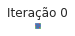

Não há mais infectados. Iteração:  18


In [55]:
y0, y1, y2, x = simulate_epidemy(N, L, s, 0.6, 0.2, n_iter=10**4, print_states=True)

In [53]:
y0, y1, y2 = simulate(L, infected=3, s=None, pc=0.6, pr=0.2)

Rodada 0
Iteração 0
Não há mais infectados. Iteração:  14
Rodada 1
Iteração 0
Não há mais infectados. Iteração:  11
Rodada 2
Iteração 0
Não há mais infectados. Iteração:  12
Rodada 3
Iteração 0
Iteração 20
Não há mais infectados. Iteração:  26
Rodada 4
Iteração 0
Não há mais infectados. Iteração:  13


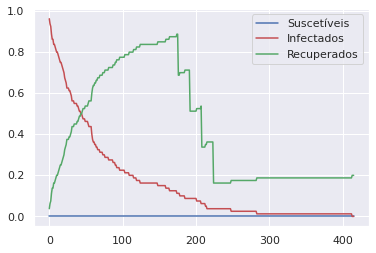

In [54]:
plt.plot(np.array(y0)/N, color='b')
plt.plot(np.array(y1)/N, color='r')
plt.plot(np.array(y2)/N, color='g')
plt.legend(["Suscetíveis","Infectados","Recuperados"])

# OFF

In [39]:
sum_different(
              np.array([0 ,15,25,35,45,55,65]),
             np.array([10,20,30,40,50]))

array([10, 35, 55, 75, 95, 55, 65])

In [40]:
np.array([0 ,15,25,35,45,55,65]) +  np.array([10,20,30,40,50])

ValueError: operands could not be broadcast together with shapes (7,) (5,) 

In [44]:
sust = np.zeros(1, dtype=np.int64)
inft = np.zeros(1, dtype=np.int64)
rect = np.zeros(1, dtype=np.int64)
print(sust)
print(inft)
print(rect)

[0]
[0]
[0]


Iteração 0
Não há mais infectados. Iteração:  13
[11  8  8  8  6  5  5  3  3  2  1  1  1  1  1  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 5  8  8  7  9 10 10 12 12 13 14 14 14 14 13 14 14 14 14 14 14 14 14 14
 14 13 13 13 13 13 13 13 12 12 12 12 12 12 11 10 10 10 10 10  9  9  9  9
  9  9  9  9  9  9  9  9  8  8  7  7  7  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  4  3  3  3 

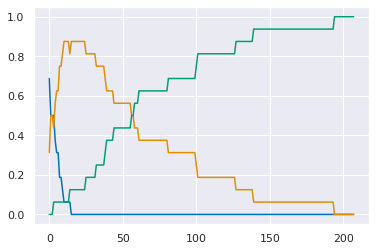

In [45]:
s0 = s.copy()
sus, inf, rec, _ = simulate_epidemy(N, L, s0, 0.6, 0.2, n_iter=10**4)
sus = np.array(sus, dtype=np.int64)
inf = np.array(inf, dtype=np.int64)
rec = np.array(rec, dtype=np.int64)

plt.plot(sus/N)
plt.plot(inf/N)
plt.plot(rec/N)
print(sus)
print(inf)
print(rec)
sust = sum_different(sust, sus)
inft = sum_different(inft, inf)
rect = sum_different(rect, rec)
print("")
print(sust)
print(inft)
print(rect)

Iteração 0
Não há mais infectados. Iteração:  16
[11  8  7  7  6  6  6  6  4  4  4  3  3  2  2  2  2  2  2  2  1  1  1  1
  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 5  8  9  8  9  8  8  8 10  9  9 10 10 11 11 11 10 10  9  9 10 10 10 10
 10 10 11 11 11 11 11 11 11 11 11 11 11 11 10 10 10 10 10  9  9  9  9  9
  9  9  9  9  9  9  9  9 

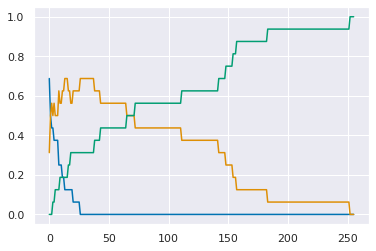

In [46]:
s0 = s.copy()
sus, inf, rec, _ = simulate_epidemy(N, L, s0, 0.6, 0.2, n_iter=10**4)
sus = np.array(sus)
inf = np.array(inf)
rec = np.array(rec)

plt.plot(sus/N)
plt.plot(inf/N)
plt.plot(rec/N)
print(sus)
print(inf)
print(rec)
sust = sum_different(sust, sus)
inft = sum_different(inft, inf)
rect = sum_different(rect, rec)
print("")
print(sust)
print(inft)
print(rect)

Iteração 0
Não há mais infectados. Iteração:  12
[12 12 12 12 10 10 10  8  8  8  8  8  8  8  8  6  6  6  6  5  4  2  2  2
  2  2  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 3  3  3  3  5  5  5  7  7  7  7  7  7  7  7  9  9  9  9 10 11 13 13 13
 13 13 13 14 15 15 15 15 15 15 15 15 15 15 15 15 15 14 14 14 14 14 13 13
 13 13 13 12 12 11 11 11 11 11 11 10 10  9  9  9  9  9  9  9  9  9  9  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  7  7  6  6  6  6  6  5
  5  4  4  4  4  4  4  4  4  4  4  4  3  3  3  3  3  3  3  3  3  3  3  3
 

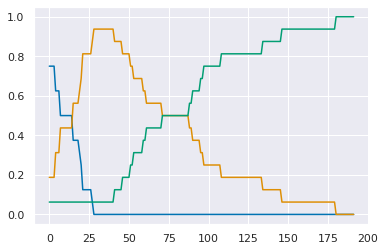

In [47]:
s0 = s.copy()
sus, inf, rec, _ = simulate_epidemy(N, L, s0, 0.6, 0.2, n_iter=10**4)
sus = np.array(sus)
inf = np.array(inf)
rec = np.array(rec)

plt.plot(sus/N)
plt.plot(inf/N)
plt.plot(rec/N)
print(sus)
print(inf)
print(rec)
sust = sum_different(sust, sus)
inft = sum_different(inft, inf)
rect = sum_different(rect, rec)
print("")
print(sust)
print(inft)
print(rect)

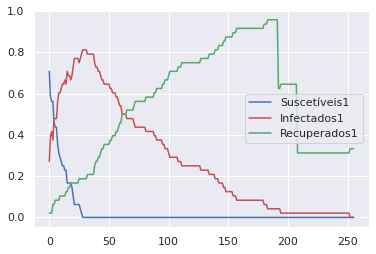

In [49]:
plt.plot((np.array(sust)/3)/N, color='b')
plt.plot((np.array(inft)/3)/N, color='r')
plt.plot((np.array(rect)/3)/N, color='g')
plt.legend(["Suscetíveis1","Infectados1","Recuperados1",
            "Suscetíveis2","Infectados2","Recuperados2",
            "Suscetíveis3","Infectados3","Recuperados3",])

Iteração 0
Não há mais infectados. Iteração:  14
Iteração 0
Não há mais infectados. Iteração:  9
Iteração 0
Não há mais infectados. Iteração:  15


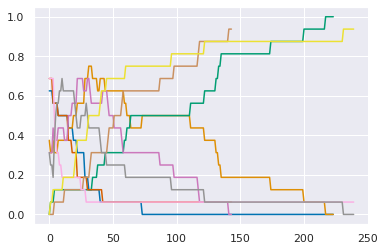

In [26]:


s0 = s.copy()
sus, inf, rec, _ = simulate_epidemy(N, L, s0, 0.6, 0.2, n_iter=10**4)
plt.plot(np.array(sus)/N)
plt.plot(np.array(inf)/N)
plt.plot(np.array(rec)/N)
sust = sum_different(sust, sus)
inft = sum_different(inft, inf)
rect = sum_different(rect, rec)

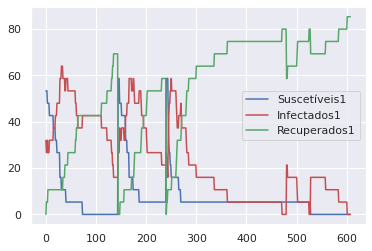

In [28]:
plt.plot(np.array(sust)/3*N, color='b')
plt.plot(np.array(inft)/3*N, color='r')
plt.plot(np.array(rect)/3*N, color='g')
plt.legend(["Suscetíveis1","Infectados1","Recuperados1",
            "Suscetíveis2","Infectados2","Recuperados2",
            "Suscetíveis3","Infectados3","Recuperados3",])

# OFF

### Plot da Rede

### GIF da Simulação

In [2]:
from pathlib import Path
import os
import imageio

def generate_gif(states):
    # Create Frames
    filenames = []
    Path("gif").mkdir(parents=True, exist_ok=True)
    index = 0
    N = len(states[0][1])
    for (n, s, descr) in states:
        plot(N, s, title=descr)

        # create file name and append it to a list
        filename = f'gif/{index}.png'
        filenames.append(filename)
        index += 1

        # repeat last frame GIF
        if (index == len(states)-1):
            for i in range(15):
                filenames.append(filename)

        # save frame
        plt.savefig(filename)
        plt.close()
    
    # build gif
    frames = []
    for filename in filenames:
        image = imageio.imread(filename)
        frames.append(image)
    imageio.mimsave('mygif2.gif', frames, format='GIF', fps=2)
            
    # Remove intermediate files used for the frames
    for filename in set(filenames):
        os.remove(filename)

In [3]:
L = 3
N = L**2
s = random_infected(N, 4)
plot(N, s)
mod_states, states = simulate_epidemy(N, L, s, 0.5, 0.5, n_iter=10**4)

NameError: name 'random_infected' is not defined

In [ ]:
generate_gif(mod_states)

<img src="mygif2.gif" width="400" align="center">

### Plot da proporção

In [ ]:
L = 100
N = L**2
s = random_infected(N, 4)
plot(N, s)

In [ ]:
L = 10
N = L**2
s = random_infected(N, 4)
plot(N, s)
mod_states, states = simulate_epidemy(N, L, s, 0.5, 0.1, n_iter=10**4)
plot(N, s)

In [ ]:
y0, y1, y2, x = histogram(states)
plt.stackplot(x,y0,y1,y2, colors=["b","r","g"])
plt.legend(["Suscetíveis","Infectados","Recuperados"])

In [ ]:
plt.plot(x,y0/N, color='b')
plt.plot(x,y1/N, color='r')
plt.plot(x,y2/N, color='g')
plt.legend(["Suscetíveis","Infectados","Recuperados"])

Obs.:
* Limitado: não simula vacinação, óbitos, reinfecção... Mas já dá uma boa ideia


In [ ]:
L = 150
N = L**2
s = random_infected(N, 20)
s

In [ ]:
plot_map(s, L)

In [ ]:
y0, y1, y2, x = simulate_epidemy(N, L, s, 0.6, 0.2, n_iter=10**4, print_states=True)

In [ ]:
y0, y1, y2 = simulate(L, s=None, pc=0.6, pr=0.2)

In [ ]:
plt.plot(np.array(y0)/N, color='b')
plt.plot(np.array(y1)/N, color='r')
plt.plot(np.array(y2)/N, color='g')
plt.legend(["Suscetíveis","Infectados","Recuperados"])

In [ ]:
plot_map(s, L)

In [ ]:


filenames = []
for index, y in enumerate(coordinates_lists):
    # plot charts
    plt.bar(x, y)
    plt.ylim(0,80)
    
    # create file name and append it to a list
    filename = f'gif/{index}.png'
    filenames.append(filename)
    
    # repeat last frame
    if (index == len(coordinates_lists)-1):
        for i in range(15):
            filenames.append(filename)
            
    # save frame
    plt.savefig(filename)
    plt.close()

# Remove files
for filename in set(filenames):
    os.remove(filename)

In [ ]:
Path("gif").rmdir()

In [ ]:
s = random_infected(N, 1)
s

In [ ]:
N = L**2
s = random_epidemy_state(N)
s

In [ ]:
simulate_epidemy(N, L, s, 0.5, 0.5)

In [ ]:
viz = neighbours(N,np.sqrt(N))
viz